In [345]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)

from keras import backend as K

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 
from keras import metrics
from keras.callbacks import ModelCheckpoint

import pandas as pd 
import math as m
import os, glob

In [346]:
import warnings
warnings.filterwarnings("ignore")

In [347]:
ID = "02"
MODEL_NAME = "M-LSTM"
NUM_FEATURES = 0
TARGET_NAME = "Close"
FRECUENCIA = "1D"
MSE_RESULT = 0

In [348]:
RANGE = 51

HYPER_L1_IN = RANGE
EPOCHS = 100
BATCH_SIZE = 1
N_STEPS= 3

TEST_SIZE = .2
VAL_SIZE = .2

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [349]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

EURUSD_ASK_1H_14F.csv
EURUSD_FULL_1D_20F.csv
EURUSD_FULL_1H_20F.csv
EURUSD_FULL_4H_20F.csv


In [350]:
if FRECUENCIA =="1D":
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
else:
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

DATASET = pd.read_csv(filenames[1], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Spread,day_name,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200
0,2004-01-01,1.25950,1.26052,1.24698,1.25733,4.621817e+05,1.25934,1.26035,1.24679,1.25723,5.597896e+05,0.00010,Thursday,3,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,2004-01-02,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.25701,1.26263,1.25198,1.25806,1.277971e+06,0.00026,Friday,4,0.000787,0.000787,0.000000,0.0,0.0,0.0
2,2004-01-04,1.25925,1.26487,1.25789,1.26318,6.879980e+04,1.25855,1.26477,1.25779,1.26308,8.372040e+04,0.00010,Sunday,6,0.003862,0.003075,0.000000,0.0,0.0,0.0
3,2004-01-05,1.26324,1.26935,1.26301,1.26830,1.119689e+06,1.26308,1.26924,1.26288,1.26820,1.353480e+06,0.00010,Monday,0,0.004053,0.000191,0.000000,0.0,0.0,0.0
4,2004-01-06,1.26836,1.28093,1.26666,1.27150,1.125442e+06,1.26820,1.28083,1.26650,1.27140,1.354807e+06,0.00010,Tuesday,1,0.002523,-0.001530,1.263726,0.0,0.0,0.0


In [351]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())

#Remove Day_name Column and Timestamp
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (5137, 20)
              Open         High          Low        Close        Volume  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03   
mean      1.263948     1.268773     1.259111     1.263939  4.156849e+05   
std       0.122827     0.123592     0.121990     0.122823  4.429918e+05   
min       1.039090     1.041820     1.034050     1.039090  5.400000e+01   
25%       1.149190     1.153490     1.145380     1.149120  1.159636e+05   
50%       1.270260     1.275990     1.265560     1.270260  2.200810e+05   
75%       1.350610     1.355180     1.345920     1.350700  7.439951e+05   
max       1.597400     1.604030     1.589800     1.597370  2.237468e+06   

          Open_Bid     High_Bid      Low_Bid    Close_Bid    Volume_Bid  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03   
mean      1.263810     1.268680     1.259015     1.263822  4.616911e+05   
std       0.122817     0.123571     0.121969     0.122813  5.305200e+05   
min  

In [352]:
#Remove first 200 rows because MA200 is 0
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(4938, 18)
      Open     High      Low    Close        Volume  Open_Bid  High_Bid  \
0  1.23655  1.23817  1.22801  1.23179  1.078729e+06   1.23639   1.23804   
1  1.23158  1.23241  1.22967  1.23109  8.212280e+04   1.23088   1.23231   
2  1.23140  1.23154  1.21310  1.21496  1.130388e+06   1.23124   1.23140   
3  1.21495  1.21669  1.20594  1.20711  1.123270e+06   1.21479   1.21656   
4  1.20718  1.21160  1.20519  1.20794  1.118725e+06   1.20702   1.21156   

   Low_Bid  Close_Bid   Volume_Bid  Spread  weekday  Pct_Range_Close  \
0  1.22791    1.23169  1291823.750  0.0001        4        -0.003680   
1  1.22955    1.23099    93508.000  0.0001        6        -0.000568   
2  1.21298    1.21486  1348137.000  0.0001        0        -0.013102   
3  1.20583    1.20701  1344214.000  0.0001        1        -0.006461   
4  1.20504    1.20784  1355827.375  0.0001        2         0.000688   

   Pct_Range_Close_diff  MA_Close_5  MA_Close_25  MA_Close_50  MA_Close_200  
0             -0.005690    

In [353]:
#Shape 
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  4938
Start:  0


In [354]:
#Shape the first START of the total and Number of Features
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

NUM_FEATURES = DF_Full.shape[1]
print("NUM_FEATURES = ",NUM_FEATURES)

(4938, 18)
NUM_FEATURES =  18


In [355]:
def get_MultiVector(Target, steps_n):
    multiVector = list()  #Lista para agregar los arrays internamente
    for i in range(Target.shape[0]): 
        end_ix = i + steps_n
        if i > Target.shape[0]-steps_n:  #Si i es mayor al final del Target ya completo el ciclo 
            for j in range(steps_n): # Ciclo para agregar al final del vector la cantidad de arrays necesarios para tener mismo shape
                multiVector.append(np.array(Target.iloc[-steps_n:]))
            break
        multiVector.append(np.array(Target.iloc[i:end_ix]))
    vector = np.asarray(multiVector, dtype=np.float32) # Se combierte la lista en array
    vector = vector[1:] # se elimina el registro 0
    return(vector)

In [356]:
#VECTOR Y

target_y = get_MultiVector(DF_Full[TARGET_NAME],N_STEPS)
print(target_y)
print(target_y.shape)

#TARGET_INDEX = DF_Full.columns.get_loc(TARGET_NAME)
#print("index column: ",TARGET_INDEX)
#print('VECTOR Y: ' + DF_Full[TARGET_NAME].name)
#close_y = DF_Full[TARGET_NAME].iloc[1:]
#close_y.columns = [TARGET_NAME+'_y']
#print(close_y.head())
#print(close_y.shape)
#close_y = close_y.append(close_y.tail(1), ignore_index=True)
#print(close_y.tail())
#print(close_y.shape)

[[1.23109 1.21496 1.20711]
 [1.21496 1.20711 1.20794]
 [1.20711 1.20794 1.21079]
 ...
 [1.10782 1.11071 1.11158]
 [1.10782 1.11071 1.11158]
 [1.10782 1.11071 1.11158]]
(4938, 3)


In [357]:
#Define INDEX for Subsets for Training, Testing and Validation

s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.4
count of Val and Test: 1975
end of train:  2963
count val:  987
count test:  987
end_val 3950


In [358]:
#Generate Subsets for Training, Testing and Validation
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print(data_training.shape)
print(data_val.shape)
print(data_test.shape)


#For Target Y Vector
data_training_y = target_y[:end_train]
data_val_y = target_y[end_train: end_val]
data_test_y = target_y[end_val:]

print(data_training_y.shape)
print(data_val_y.shape)
print(data_test_y.shape)

(2963, 18)
(987, 18)
(988, 18)
(2963, 3)
(987, 3)
(988, 3)


In [359]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(-1, 1))
#print(data_training.head)
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[-0.67743585 -0.69328674 -0.70006109 ... -0.78231973 -0.77500375
  -0.8501711 ]
 [-0.70053923 -0.71994539 -0.6922607  ... -0.77799382 -0.77353612
  -0.85095764]
 [-0.70137598 -0.72397195 -0.77012358 ... -0.7771235  -0.77384678
  -0.85225736]
 ...
 [-0.15586649 -0.15918821 -0.13744655 ... -0.08195894 -0.04589644
  -0.14522054]
 [-0.13936408 -0.15775345 -0.12983412 ... -0.08420992 -0.0478667
  -0.14473735]
 [-0.14261807 -0.14993173 -0.12724966 ... -0.08585958 -0.04996597
  -0.14422358]]


(2963, 18)


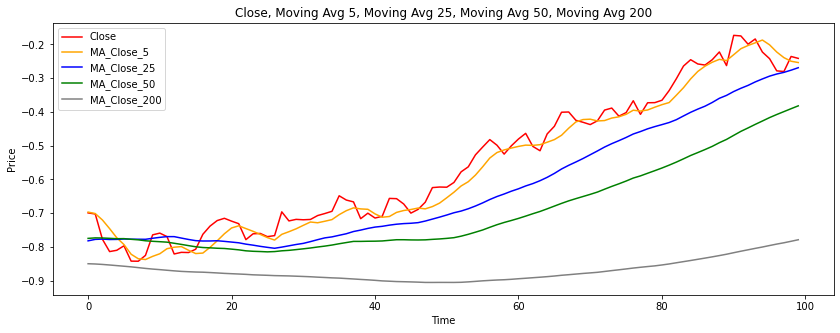

In [360]:
INICIO = 0
FIN = 100

IDX_Close = DF_Full.columns.get_loc("Close")
IDX_MA_Close_5 = DF_Full.columns.get_loc("MA_Close_5")
IDX_MA_Close_25 = DF_Full.columns.get_loc("MA_Close_25")
IDX_MA_Close_50 = DF_Full.columns.get_loc("MA_Close_50")
IDX_MA_Close_200 = DF_Full.columns.get_loc("MA_Close_200")

print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_5], color = 'orange', label = 'MA_Close_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_25], color = 'blue', label = 'MA_Close_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_50], color = 'green', label = 'MA_Close_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_200], color = 'gray', label = 'MA_Close_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(2963, 18)


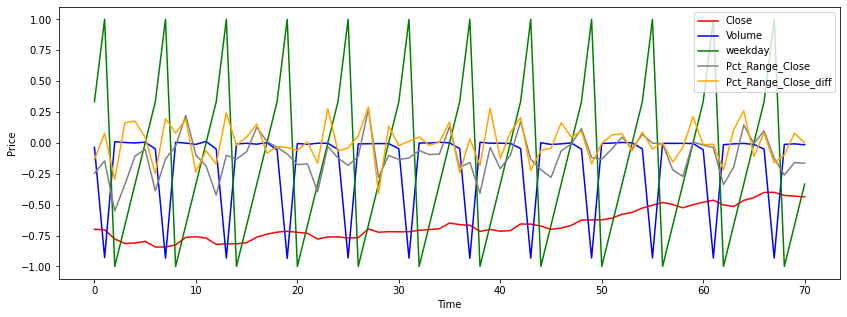

In [361]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 71


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Volume = DF_Full.columns.get_loc("Volume")
IDX_weekday = DF_Full.columns.get_loc("weekday")
IDX_Pct_Range_Close = DF_Full.columns.get_loc("Pct_Range_Close")
IDX_Pct_Range_Close_diff = DF_Full.columns.get_loc("Pct_Range_Close_diff")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Volume], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_weekday], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close_diff], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(2963, 18)


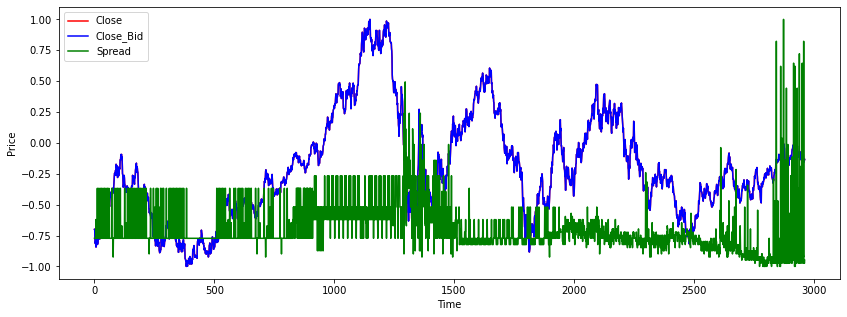

In [362]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 2963


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Close_Bid = DF_Full.columns.get_loc("Close_Bid")
IDX_Spread = DF_Full.columns.get_loc("Spread")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close_Bid], color = 'blue', label = 'Close_Bid')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Spread], color = 'green', label = 'Spread')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(2963, 18)


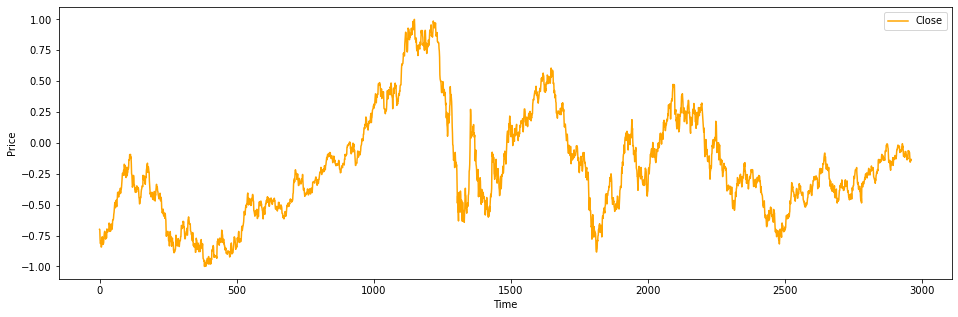

In [363]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 10377
plt.figure(figsize=(16,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX], color = 'orange', label = TARGET_NAME)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

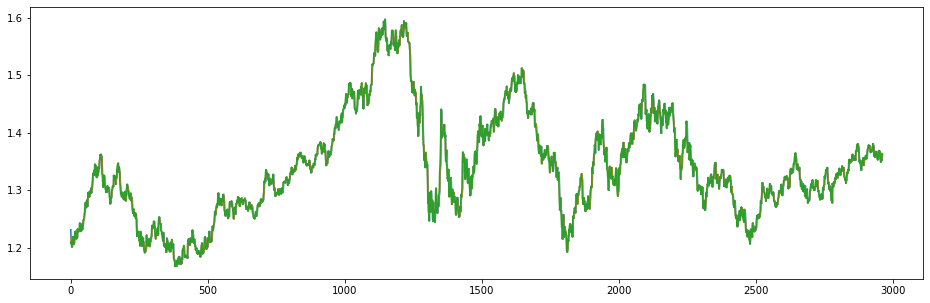

In [364]:
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [365]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(2912, 51, 18)
(2912, 3)


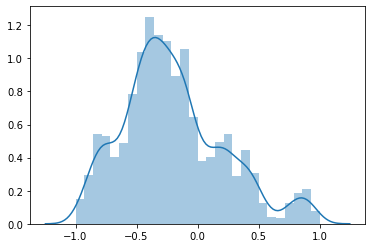

In [366]:
sns.distplot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX]);


In [367]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(51, 18)
(987, 18)
<bound method NDFrame.head of          Open     High      Low    Close       Volume  Open_Bid  High_Bid  \
0     1.37066  1.37471  1.36946  1.37374  153247.4688   1.37064   1.37457   
1     1.37372  1.37955  1.37344  1.37646  195586.4531   1.37370   1.37948   
2     1.37646  1.38110  1.37411  1.37854  185280.8906   1.37641   1.38107   
3     1.37855  1.38033  1.37380  1.37499  210793.7969   1.37850   1.38032   
4     1.37500  1.37697  1.37097  1.37455  173793.7656   1.37496   1.37691   
...       ...      ...      ...      ...          ...       ...       ...   
1033  1.08167  1.08269  1.07403  1.07588  173213.3750   1.08162   1.08264   
1034  1.07588  1.07683  1.06724  1.06879  166713.5000   1.07582   1.07679   
1035  1.06881  1.07020  1.06522  1.06561  185265.9219   1.06875   1.07018   
1036  1.06666  1.06741  1.06590  1.06697    8386.2197   1.06594   1.06737   
1037  1.06697  1.06813  1.06426  1.06701  170208.7656   1.06692   1.06809   

      Low_Bid  Close_Bid  

In [368]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y[-RANGE:]
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = np.concatenate((last_range_train_y,data_val_y))
data_val_y1.shape
print(data_val_y1[:10])

(51, 3)
(987, 3)
[[1.37646 1.37854 1.37499]
 [1.37854 1.37499 1.37455]
 [1.37499 1.37455 1.37382]
 [1.37455 1.37382 1.37611]
 [1.37382 1.37611 1.37695]
 [1.37611 1.37695 1.36826]
 [1.37695 1.36826 1.36558]
 [1.36826 1.36558 1.36768]
 [1.36558 1.36768 1.36777]
 [1.36768 1.36777 1.36976]]


In [369]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[-0.05401636 -0.06134728 -0.03538368 -0.03955932 -0.86443602 -0.05327755
  -0.06122449 -0.0346416  -0.0391464  -0.88598058 -0.92405063 -1.
  -0.05627202  0.05749842 -0.05839109 -0.10791047 -0.08611279 -0.23287078]
 [-0.03979174 -0.03894661 -0.01668155 -0.02691521 -0.82656176 -0.0390516
  -0.03850248 -0.01579318 -0.02650053 -0.85886579 -0.92405063 -0.66666667
  -0.06394781 -0.00215271 -0.0412791  -0.10085094 -0.08395469 -0.23075244]
 [-0.02705467 -0.03177285 -0.0135332  -0.01724619 -0.83578058 -0.02645281
  -0.03114443 -0.01287897 -0.01687666 -0.86211431 -0.89873418 -0.33333333
  -0.07907918 -0.00771495 -0.03014196 -0.09397735 -0.08159328 -0.22857746]
 [-0.01733916 -0.03533659 -0.0149899  -0.03374861 -0.81295806 -0.0167364
  -0.03461521 -0.01452409 -0.03328839 -0.84921548 -0.94936709  0.
  -0.21095154 -0.09480972 -0.0260695  -0.08872968 -0.07922154 -0.22631255]
 [-0.03384158 -0.05088746 -0.02828814 -0.03579398 -0.84605637 -0.03319386
  -0.05039567 -0.02777908 -0.03826305 -0.8713956   0

In [370]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(987, 51, 18)
(987, 3)


In [371]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(51, 18)
(988, 18)


(1039, 18)

In [372]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y[-RANGE:]
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = np.concatenate((last_range_training_y,data_test_y))
data_test_y1.shape

(51, 3)
(988, 3)


(1039, 3)

In [373]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[-0.05401636 -0.06134728 -0.03538368 -0.03955932 -0.86443602 -0.05327755
  -0.06122449 -0.0346416  -0.0391464  -0.88598058 -0.92405063 -1.
  -0.05627202  0.05749842 -0.05839109 -0.10791047 -0.08611279 -0.23287078]
 [-0.03979174 -0.03894661 -0.01668155 -0.02691521 -0.82656176 -0.0390516
  -0.03850248 -0.01579318 -0.02650053 -0.85886579 -0.92405063 -0.66666667
  -0.06394781 -0.00215271 -0.0412791  -0.10085094 -0.08395469 -0.23075244]
 [-0.02705467 -0.03177285 -0.0135332  -0.01724619 -0.83578058 -0.02645281
  -0.03114443 -0.01287897 -0.01687666 -0.86211431 -0.89873418 -0.33333333
  -0.07907918 -0.00771495 -0.03014196 -0.09397735 -0.08159328 -0.22857746]
 [-0.01733916 -0.03533659 -0.0149899  -0.03374861 -0.81295806 -0.0167364
  -0.03461521 -0.01452409 -0.03328839 -0.84921548 -0.94936709  0.
  -0.21095154 -0.09480972 -0.0260695  -0.08872968 -0.07922154 -0.22631255]
 [-0.03384158 -0.05088746 -0.02828814 -0.03579398 -0.84605637 -0.03319386
  -0.05039567 -0.02777908 -0.03826305 -0.8713956   0

In [374]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(988, 51, 18)
(988, 3)


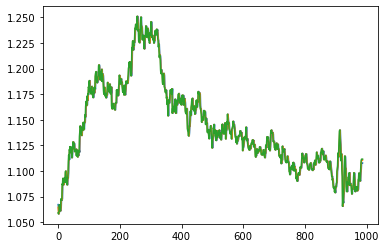

In [375]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

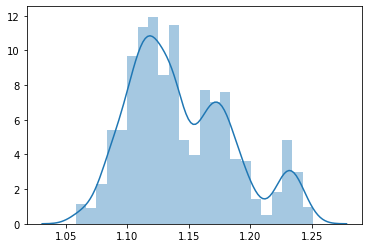

In [376]:
sns.distplot(y_test_np);


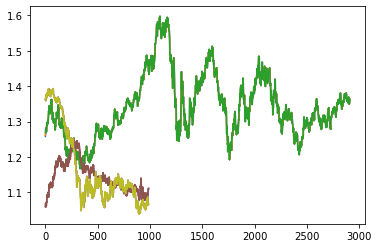

In [377]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [378]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

51
18


In [379]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))
#regressior.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))
#regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))
regressior.add(LSTM(units = 60, activation = 'relu'))
#regressior.add(Dropout(0.2))
regressior.add(Dense(units = N_STEPS))

In [380]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [381]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [382]:
regressior.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 51, 51)            14280     
_________________________________________________________________
lstm_13 (LSTM)               (None, 60)                26880     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 183       
Total params: 41,343
Trainable params: 41,343
Non-trainable params: 0
_________________________________________________________________


In [383]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/LSTM/')
print(source_data)

C:\Users\marami3\Documents\ITESO\IDI4\forex_prediction\Jupyter Notebooks\IDI4\models\../../../Models/2020/LSTM/


In [384]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [385]:
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)



Epoch 1/100
2912/2912 [==============================] - 42s 14ms/step - loss: 1422.1547 - mean_squared_error: 1422.1547 - mean_absolute_error: 0.7948 - mean_absolute_percentage_error: 52.3688 - cosine_proximity: 0.9987 - val_loss: 33.4347 - val_mean_squared_error: 33.4347 - val_mean_absolute_error: 1.8249 - val_mean_absolute_percentage_error: 169.5274 - val_cosine_proximity: 0.9788
Epoch 2/100
2912/2912 [==============================] - 41s 14ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 1.9295 - cosine_proximity: 0.9999 - val_loss: 0.2912 - val_mean_squared_error: 0.2912 - val_mean_absolute_error: 0.3244 - val_mean_absolute_percentage_error: 29.8201 - val_cosine_proximity: 0.9978
Epoch 3/100
2912/2912 [==============================] - 39s 13ms/step - loss: 7.9444e-04 - mean_squared_error: 7.9444e-04 - mean_absolute_error: 0.0218 - mean_absolute_percentage_error: 1.6281 - cosine_proximity: 1.0000 - val_loss: 0.018

2912/2912 [==============================] - 38s 13ms/step - loss: 3.4722e-04 - mean_squared_error: 3.4722e-04 - mean_absolute_error: 0.0145 - mean_absolute_percentage_error: 1.0812 - cosine_proximity: 1.0000 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0339 - val_mean_absolute_percentage_error: 3.0300 - val_cosine_proximity: 1.00006e-04 - mean_squared_error: 2.7236e-04 - mean_absolute_error: 0.0129 -  - ETA: 28s - loss: 3.3708e-04 - mean_squared_error: 3.3708e-04 - mean_absolute_error: 0.0141 - mean_absolute_percentage_err - ETA: 25s - loss: 3.4673e-04 - mean_squared_error: 3.4673e-04 - ETA: 19s - loss: 3.6755e-04 - mean_squared_error: 3.6755e-04 - mean_absolute_error: 0.0148 - mean_absolute_percentage_error: 1.1016 - cosine_proxim - ETA: 19s - loss: 3.6523e-04 - mean_squared_error: 3.6523e-04 - mean_absolute_error: 0.0148 - mean_absol - ETA: 15s - loss: 3.5360e-04 - mean_squared_error: 3.5360e-04 - mean_absolute_error: 0.0146 - mean_absolute_percen

2912/2912 [==============================] - 39s 13ms/step - loss: 2.2594e-04 - mean_squared_error: 2.2594e-04 - mean_absolute_error: 0.0118 - mean_absolute_percentage_error: 0.8781 - cosine_proximity: 1.0000 - val_loss: 4.9417e-04 - val_mean_squared_error: 4.9417e-04 - val_mean_absolute_error: 0.0168 - val_mean_absolute_percentage_error: 1.5215 - val_cosine_proximity: 1.0000or: 2.5388e-04 - mean_absolute_error: 0.0 - ETA: 27s - loss: 2.3371e-04 - mean_squared_error: 2.3371e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 0.8828 - cosine_proximity: 1 - ETA: 26s - loss: 2.3488e-04 - mean_squared_error: 2.3488e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 0.8854 - cosine_proxi - ETA: 26s - loss: 2.3470e-04 - mean_squared_error: 2.3470e-04  - ETA: 20s - loss: 2.2958e-04 - mean_squared_error: 2.2958e-04 - mean_abs - ETA: 15s - loss: 2.3410e-04 - mean_squared_error: 2.3410e-04 - mean_absolute_error: 0.0121 - mean_absolute_perce - ETA: 12s - loss: 2.3

2912/2912 [==============================] - 38s 13ms/step - loss: 2.0554e-04 - mean_squared_error: 2.0554e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 0.8363 - cosine_proximity: 1.0000 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0303 - val_mean_absolute_percentage_error: 2.7186 - val_cosine_proximity: 1.0000rror: 1.9970e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 0.8400 - cosine_p - ETA: 29s - loss: 2.0824e-04 - mean_squared_error: 2.0824e-04 - mean_absolute_error: 0.0114 - mean_absolu - ETA: 25s - loss: 2.0364e-04 - mean_squared_error: 2.0364e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentag - ETA: 23s - loss: 1.9824e-04 - mean_squared_error: 1.9824e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 0.8244 - cosine_proximity: 1.000 - ETA: 23s - loss: 1.9756e-04 - mean_squared_error: 1.9756e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 0.8227 - cosine_pr

2912/2912 [==============================] - 38s 13ms/step - loss: 1.7191e-04 - mean_squared_error: 1.7191e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 0.7653 - cosine_proximity: 1.0000 - val_loss: 9.7361e-04 - val_mean_squared_error: 9.7361e-04 - val_mean_absolute_error: 0.0249 - val_mean_absolute_percentage_error: 2.2457 - val_cosine_proximity: 1.0000ss: 1.6160e-04 - mean_squared_error: 1.6160e-04 - mean_absolute_error: 0.0101 - mean_absolute_percentage_error: 0.7475 - - ETA: 32s - loss: 1.7857e-04 - mean_squared_error: 1.7857e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 0.7848 - cosine_proxi - ETA: 31s - loss: 1.7283e-04 - mean_squared_error: 1.7283e-04 - mean_absolute_error: 0.0103 -  - ETA: 27s - loss: 1.6989e-04 - mean_squared_error: 1.6989e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 0.7703 - cosine_proximity: 1 - ETA: 27s - loss: 1.7550e-04 - mean_squared_error: 1.7550e-04 - mean_absolute_error: 0.0105 - mean_

2912/2912 [==============================] - 38s 13ms/step - loss: 1.4187e-04 - mean_squared_error: 1.4187e-04 - mean_absolute_error: 0.0093 - mean_absolute_percentage_error: 0.6971 - cosine_proximity: 1.0000 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0260 - val_mean_absolute_percentage_error: 2.3413 - val_cosine_proximity: 1.0000n_squared_error: 1.3312e-04 - mean_absolute_error: 0.0091 - mean_absolute_percentage_error: 0.6855 - cosine_pro - ETA: 31s - loss: 1.3307e-04 - mean_squared_error: 1.3307e-04 - mean_absolute_error: 0.0091 - mean_absolute_percentage_error: 0.6890 - cosine_p - ETA: 30s - loss: 1.3918e-04 - mean_squared_error: 1.3918e-04 - mean_absolute_error: 0.0094 - mean_absolute_percentage_ - ETA: 28s - loss: 1.3515e-04 - mean_squared_error: 1.3515e-04 - mean_absolute_error: 0.0091 - mean_absolut - ETA: 25s - loss: 1.3423e-04 - mea - ETA: 18s - loss: 1.4612e-04 - mean_squared_error: 1.4612e-04 - mean_absolute_error: 0.0094 - mean_absolute

2912/2912 [==============================] - 39s 13ms/step - loss: 1.1977e-04 - mean_squared_error: 1.1977e-04 - mean_absolute_error: 0.0086 - mean_absolute_percentage_error: 0.6432 - cosine_proximity: 1.0000 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0313 - val_mean_absolute_percentage_error: 2.8072 - val_cosine_proximity: 1.000033s - loss: 1.1733e - ETA: 27s - loss: 1.1445e-04 - mean_squared_error: 1.1445e-04 - mean_absolute_error: 0.0085 - mean_absolute_percentage_error: 0.6 - ETA: 25s - loss: 1.1296e-04 - mean_squared_error: 1.1296e-04 - mean_absolute_error: 0.0084 - mean_absolute_percentage_error: 0.6283 - cosine_proxim - ETA: 24s - loss: 1.1514e-04 - mean_squared_error: 1.1514e-04 - mean_abso - ETA: 19s - loss: 1.1757e-04 - mean_squared_error: 1.1757e-04 - mean_absolute_error: 0.0086 - mean_absolute_percentage_error: 0.6428 -  - ETA: 18s - loss: 1.1726e-04 - mean_squared_error: 1.1726e-04 - mean_absolute_error: 0.0086 - ETA: 14s - loss: 1.186

2912/2912 [==============================] - 38s 13ms/step - loss: 1.1509e-04 - mean_squared_error: 1.1509e-04 - mean_absolute_error: 0.0084 - mean_absolute_percentage_error: 0.6320 - cosine_proximity: 1.0000 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0302 - val_mean_absolute_percentage_error: 2.7255 - val_cosine_proximity: 0.9999- loss: 9.7581e-05 - mean_squared_error: 9.7581e-05 - mean_absolute_error: 0.0078 - mean_absolute_percentage_error: 0 - ETA: 31s - loss: 9.5987e-05 - mean_squared_error: 9.5987e-05 - mean_absolute_error: 0.
Epoch 89/100
2912/2912 [==============================] - 39s 13ms/step - loss: 1.1534e-04 - mean_squared_error: 1.1534e-04 - mean_absolute_error: 0.0084 - mean_absolute_percentage_error: 0.6321 - cosine_proximity: 1.0000 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0407 - val_mean_absolute_percentage_error: 3.6747 - val_cosine_proximity: 0.9999 - loss: 9.3160e-05 - mean_squared_error

2912/2912 [==============================] - 39s 13ms/step - loss: 1.0415e-04 - mean_squared_error: 1.0415e-04 - mean_absolute_error: 0.0080 - mean_absolute_percentage_error: 0.6026 - cosine_proximity: 1.0000 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0386 - val_mean_absolute_percentage_error: 3.4878 - val_cosine_proximity: 0.9999 1.1841e-04 - mean_squared_error: 1.1841e-04 - mean_absolute_error: 0.0086 - mean_absolute_percentage_e - ETA: 31s - loss: 1.0212e-04 - mean_squared_error: 1.0212e-04 - mean_absolute_error: 0.0080 - mean_absolute_percentage_error: 0.6000 - cosine_proximit - ETA: 30s - loss: 1.0349e-04 - mean_squared_error: 1.0349e-04 - mean_absolute_error: 0.0081 - mean_absolute_ - ETA: 27s - loss: 1.0184e-04 - mean_squared_error: 1.0184e-04 - mean_absolute_error:  - ETA: 23s - loss: 1.0162e-04 - mean_squared_error: 1.0162e-04 - mean_absolute_error: 0.0080 - mean_absolute_percentage_error: 0.5991 - cosine_prox - ETA: 22s - loss: 1.0243e-04

In [615]:
file_name = MODEL_NAME + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + TARGET_NAME + "_"+ ID + '.hdf5'
print(file_name)

M-LSTM_1D_18F_Close_01.hdf5


In [616]:
regressior.save(source_data + file_name)

In [617]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_cosine_proximity'])


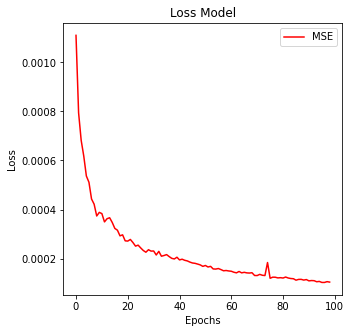

In [618]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['mean_squared_error'][1:], color = 'red', label = 'MSE')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

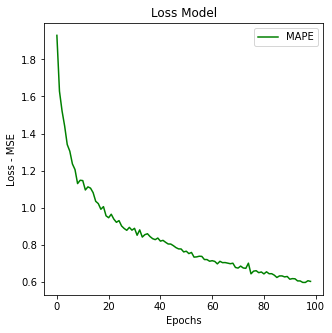

In [619]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
plt.plot(history.history['mean_absolute_percentage_error'][1:], color = 'green', label = 'MAPE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()
plt.show()


In [620]:
#Load Model
filepath = os.path.join(source_data, file_name)
print(filepath)
model = tf.keras.models.load_model(filepath)

C:\Users\marami3\Documents\ITESO\IDI4\forex_prediction\Jupyter Notebooks\IDI4\models\../../../Models/2020/LSTM/M-LSTM_1D_18F_Close_01.hdf5


In [621]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape



(988, 3)

In [622]:
y_test_pred[:10]

array([[1.3624907, 1.3663493, 1.3667891],
       [1.4381909, 1.354191 , 1.3395827],
       [1.3184955, 1.2677915, 1.2518686],
       [1.2191546, 1.1865271, 1.1710204],
       [1.1700735, 1.1500466, 1.1372304],
       [1.1437706, 1.1281865, 1.1174294],
       [1.1320302, 1.1246789, 1.1177301],
       [1.1315274, 1.1182852, 1.1101133],
       [1.1262009, 1.1216655, 1.117583 ],
       [1.1341031, 1.1176515, 1.1112008]], dtype=float32)

In [623]:
X_test_np.shape

(988, 51, 18)

In [625]:
X_test_np[:1,:,3]

array([[-0.03955932, -0.02691521, -0.01724619, -0.03374861, -0.03579398,
        -0.03918743, -0.02854221, -0.02463741, -0.06503347, -0.07749163,
        -0.06772964, -0.06731127, -0.05806062, -0.06763667, -0.07037932,
        -0.05926925, -0.03388806, -0.03300483, -0.00646151, -0.03518966,
        -0.02593901, -0.07293604, -0.10807921, -0.10533656, -0.08953142,
        -0.09534213, -0.11658609, -0.10036259, -0.0694961 , -0.06982149,
        -0.07130904, -0.07214578, -0.10352361, -0.09594645, -0.13029937,
        -0.13722573, -0.12839345, -0.12309409, -0.12936965, -0.0623373 ,
        -0.06610264, -0.0629881 , -0.06879881, -0.07818892, -0.07651543,
        -0.1230476 , -0.15456489, -0.15572704, -0.1392711 , -0.14243213,
        -0.13411119]])

In [626]:
y_test_np[:5]

array([[1.0672 , 1.06443, 1.05919],
       [1.06443, 1.05919, 1.05808],
       [1.05919, 1.05808, 1.05976],
       [1.05808, 1.05976, 1.06105],
       [1.05976, 1.06105, 1.06704]], dtype=float32)

In [627]:
y_test_pred[0]

array([1.3624907, 1.3663493, 1.3667891], dtype=float32)

NameError: name 'f' is not defined

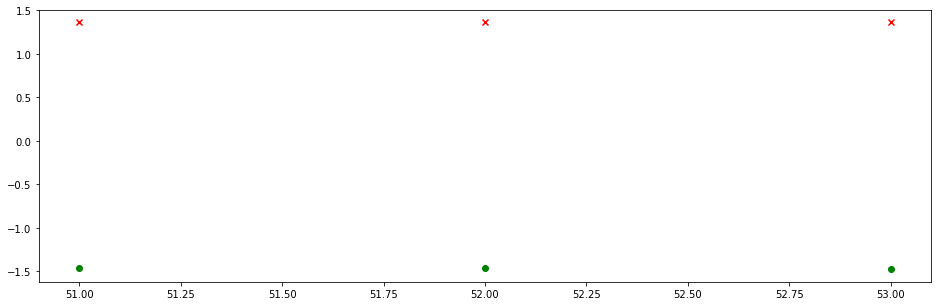

In [628]:
STEP = 0
CLOSE_INDX = 3
NEXT_REAL_VAL1 = X_test_np[STEP+1,-1,CLOSE_INDX]
NEXT_REAL_VAL2 = X_test_np[STEP+2,-1,CLOSE_INDX]
NEXT_REAL_VAL3 = X_test_np[STEP+3,-1,CLOSE_INDX]
PRED_1 = y_test_pred[STEP][0]
PRED_2 = y_test_pred[STEP][1]
PRED_3 = y_test_pred[STEP][2]

pyplot.figure(figsize=(16,5))
plt.scatter(RANGE, NEXT_REAL_VAL1, c='green')
plt.scatter(RANGE+1, NEXT_REAL_VAL2, c='green')
plt.scatter(RANGE+2, NEXT_REAL_VAL3, c='green')

plt.scatter(RANGE, PRED_1, marker='x', color='r')
plt.scatter(RANGE+1, PRED_1, marker='x', color='r')
plt.scatter(RANGE+2, PRED_1, marker='x', color='r')
plt.plot(f[STEP,:,CLOSE_INDX])
plt.show()

In [531]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape


(2912, 3)

(988, 3)
(988, 3)


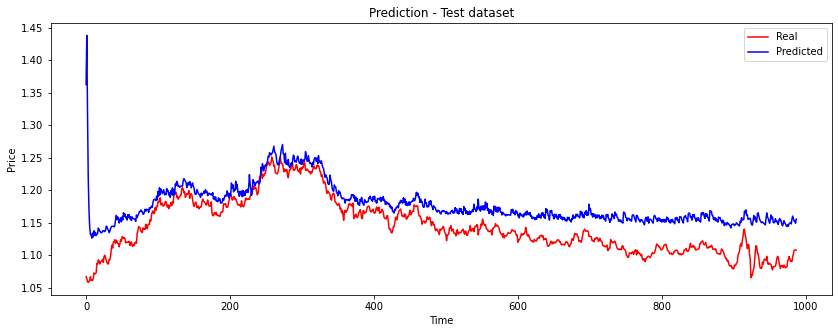

In [549]:
INICIO = 0
FIN = 1000
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[:,0], color = 'red', label = 'Real')
plt.plot(y_test_pred[:,0], color = 'blue', label = 'Predicted')
plt.title('Prediction - Test dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [398]:
print(data_test.head)

<bound method NDFrame.head of          Open     High      Low    Close       Volume  Open_Bid  High_Bid  \
3950  1.06701  1.06857  1.06359  1.06782  170423.0938   1.06695   1.06851   
3951  1.06783  1.06894  1.06360  1.06720  193692.2969   1.06779   1.06889   
3952  1.06719  1.06843  1.06294  1.06443  177556.9063   1.06715   1.06840   
3953  1.06441  1.06674  1.05809  1.05919  193896.7031   1.06437   1.06659   
3954  1.05894  1.05903  1.05738  1.05808   10151.2598   1.05866   1.05885   
...       ...      ...      ...      ...          ...       ...       ...   
4933  1.09019  1.09960  1.08970  1.09787  221915.4388   1.09015   1.09957   
4934  1.09788  1.10311  1.09342  1.10169  339215.8879   1.09785   1.10307   
4935  1.10168  1.10937  1.09919  1.10782  290715.4826   1.10165   1.10934   
4936  1.10780  1.11452  1.10702  1.11071  330692.3901   1.10778   1.11451   
4937  1.11213  1.11217  1.11028  1.11158   10126.4174   1.11129   1.11195   

      Low_Bid  Close_Bid   Volume_Bid   Sprea

In [550]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [551]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error


Test MAE: 0.030769236
Test RMSE: 0.037059028
Test MSE: 0.0013733715
Test MAPE: 2.7359353378415108


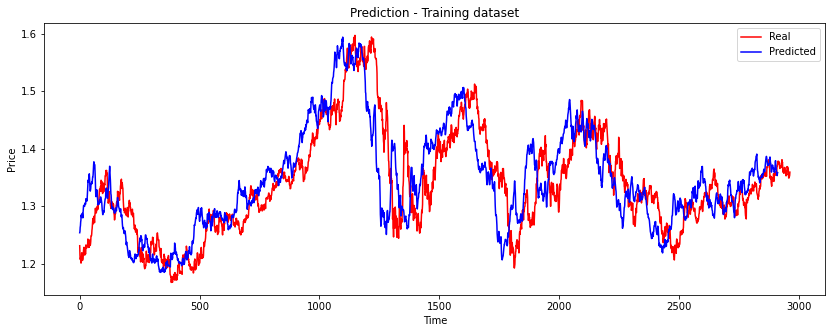

In [614]:

# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(data_training_y[:,0], color = 'red', label = 'Real')
plt.plot(y_train_pred[:,0], color = 'blue', label = 'Predicted')
plt.title('Prediction - Training dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend() 
plt.show()


In [555]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error


Train MAE: 0.007355617
Train RMSE: 0.0091922665
Train MSE: 8.449777e-05
Test MAPE: 0.5532757844775915


In [590]:
print(y_train_np.shape)
print(y_train_pred.shape)
print(X_train_np.shape)

(2912, 3)
(2912, 3)
(2912, 51, 18)


In [611]:
data_training_y[RANGE,0]

1.25798

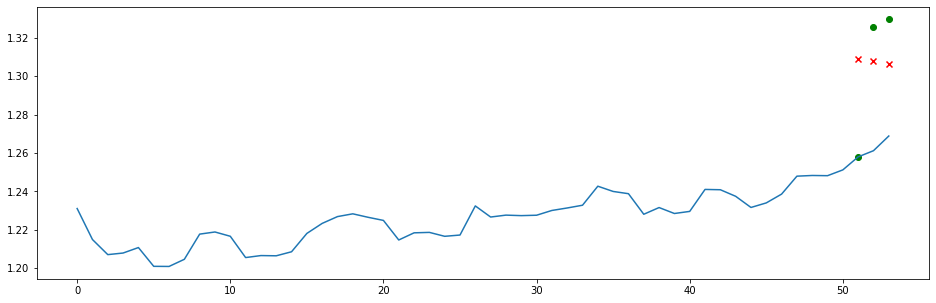

In [613]:
STEP = 30
CLOSE_INDX = 3
NEXT_REAL_VAL1 = data_training_y[RANGE,0]
NEXT_REAL_VAL2 = y_train_np[STEP,1]
NEXT_REAL_VAL3 = y_train_np[STEP,2]
PRED_1 = y_train_pred[STEP][0]
PRED_2 = y_train_pred[STEP][1]
PRED_3 = y_train_pred[STEP][2]

pyplot.figure(figsize=(16,5))
plt.scatter(RANGE, NEXT_REAL_VAL1, c='green')
plt.scatter(RANGE+1, NEXT_REAL_VAL2, c='green')
plt.scatter(RANGE+2, NEXT_REAL_VAL3, c='green')

plt.scatter(51, PRED_1, marker='x', color='r')
plt.scatter(52, PRED_2, marker='x', color='r')
plt.scatter(53, PRED_3, marker='x', color='r')

plt.plot(data_training_y[:54,0])

plt.show()